In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
%%capture
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_palette('colorblind')
sns.set_style('whitegrid')
!pip install pingouin
import pingouin
from spacy.lang.en.stop_words import STOP_WORDS
from nltk import word_tokenize
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
!pip install --upgrade scipy
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
!pip install lightgbm --install-option=--gpu
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
!pip install contractions
import contractions
from collections import Counter
import re
from tqdm import tqdm
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

# Loading the Dataset

We will start by loading our data, then dropping any duplicates. After that we will check the shape to understand the amount of data we are working with.

In [3]:
movies = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
movies.drop_duplicates(inplace = True)
display(movies.head())

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


We can see that our data has 49582 records and 2 columns. This is a lot of data especially when you consider that it is a Natural Language Processing task we are working on. As such, we will take a random sample of 10000 records to work with.

# Sampling

In [4]:
movies_copy = movies.copy()
movies_df = movies_copy.sample(n = 5000, random_state = 42).reset_index(drop = True)
movies_df.head()

,review,sentiment
0,"""Soul Plane"" is a horrible attempt at comedy t...",negative
1,Guest from the Future tells a fascinating stor...,positive
2,"""National Treasure"" (2004) is a thoroughly mis...",negative
3,"OK. First said, I just wanted to check whether...",negative
4,"I haven't always been a fan, but the show grew...",positive


# Exploratory Data Analysis

## How many positive and negative reviews are there?

We will use a countplot to answer the above asked question;

sentiment
negative    2510
positive    2490
Name: count, dtype: int64


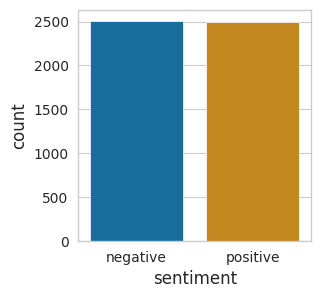

In [5]:
print(movies_df.sentiment.value_counts())
plt.figure(figsize = (3,3))
sns.countplot(data = movies_df, x = 'sentiment')
plt.show()

From the above countplot, we can see that negative and positive reviews are balanced. This is good as the Machine Learning models that will be fit later to predict sentiment will have a lot of data to learn from, from both classes.

## Is there a difference between the number of characters in negative and positive reviews?

100%|██████████| 5000/5000 [00:00<00:00, 628473.13it/s]


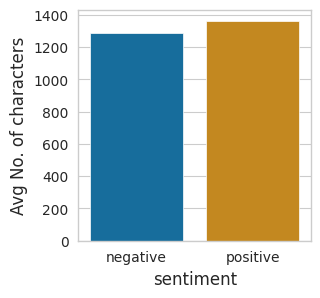

In [6]:
## Creating a new column of number of characters in reviews.
tqdm.pandas()
movies_df['num_char'] = movies_df['review'].progress_apply(lambda x: len(x))
# Plotting a barplot of average num_char vs sentiment
plt.figure(figsize = (3,3))
sns.barplot(data = movies_df, x = 'sentiment', y = 'num_char', ci = False)
plt.ylabel('Avg No. of characters')
plt.show()

From the above barplot, we can see that there is a slight difference in the average number of characters between positive and negative reviews.

We will conduct a t-test to test this out but before then, we will have a look at the distribution of number of characters across the 2 categories of sentiments.

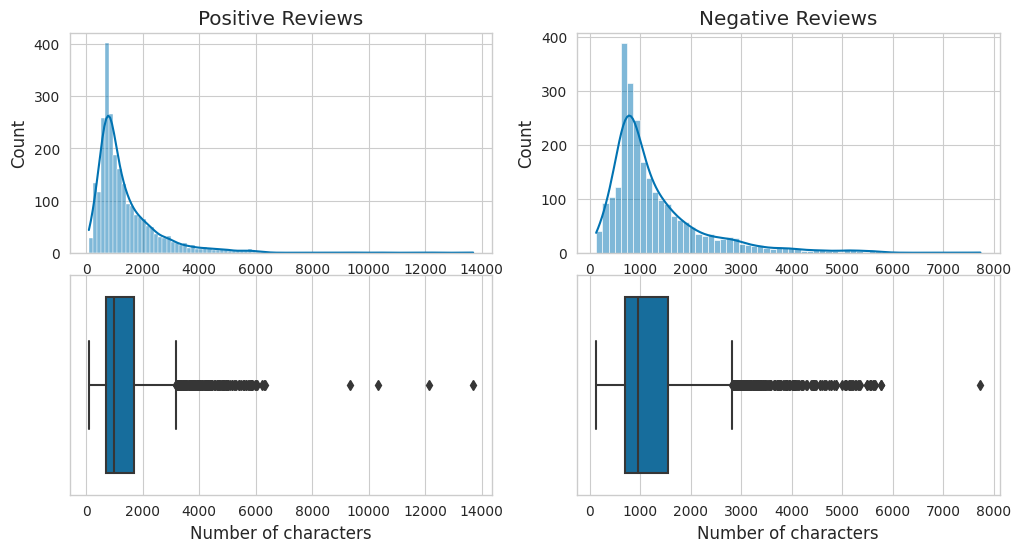

In [7]:
fig, ax =plt.subplots(2,2, figsize = (12,6))
sns.histplot(data = movies_df[movies_df['sentiment']=='positive'], x = 'num_char',  ax =ax[0,0], kde = True)
ax[0,0].set_title("Positive Reviews")
ax[0,0].set_xlabel('Number of characters')
sns.histplot(data = movies_df[movies_df['sentiment']=='negative'], x = 'num_char',  ax =ax[0,1], kde = True)
ax[0,1].set_title("Negative Reviews")
ax[0,1].set_xlabel('Number of characters')
sns.boxplot(data = movies_df[movies_df['sentiment']=='positive'], x = 'num_char', ax = ax[1,0])
ax[1,0].set_xlabel('Number of characters')
sns.boxplot(data = movies_df[movies_df['sentiment']=='negative'], x = 'num_char', ax = ax[1,1])
ax[1,1].set_xlabel('Number of characters')
plt.subplots_adjust(hspace=0.1)
plt.show()

From the above plots, we can see that any review of length more than 6000 is an extreme otlier in either negative or positive reviews. We can also see that we have more extreme `num_char` values in positive reviews than in negative ones.

Next, we will have a look at these entries just to confirm that they are indeed valid entries and not erroneous texts.

In [8]:
#Subsetting for num_char outliers
numchar_outlier = movies_df[movies_df['num_char']>=6000]

The values were checked using the following command;
```{python}
numchar_outlier['review'].values
```
And they are all valid entries.

## Is the difference in number of characters significant?

We will answer this question through hypothesis testing.

H0: The average number of characters across positive and negative reviews is equal.

H1: The average number of characters in positive reviews is greater than average number of characters in negative reviews.

In [9]:
# subsetting for positive and negative reviews
positive_df = movies_df[movies_df['sentiment']=='positive']
negative_df = movies_df[movies_df['sentiment']=='negative']
#performing the hypothesis test
pingouin.mwu(x = positive_df['num_char'],
              y = negative_df['num_char'],
              alternative = 'greater')

,U-val,alternative,p-val,RBC,CLES
MWU,3183296.5,greater,0.12647,0.018671,0.509336


From the above, a p-value of 0.392 suggest that we fail to reject the null and conclude that there is no significant difference in the number of characters in positive and negative reviews.

A RBC (Rank Biserial Correlation) value of 0.003 suggests that positive reviews have slightly more characters than negative reviews but the effect is very small.

Lastly, a CLES (Common Language Effect Size) value 0.5015 suggests that there is approximately a 50% chance of getting a positive review with more characters than a negative review.

## Is there a significant difference between the number of words in positive reviews and negative reviews?

To answer the above question, we will start by expanding contractions using `contractions.fix()`. After that, we will remove punctuations and other unwanted characters such as HTML tags. Next, we will lemmatize and lastly, everything will be converted to lower case.

In [10]:
#Expanding contractions.
movies_df['clean_review'] = movies_df['review'].progress_apply(lambda x: contractions.fix(x))
# Removing tags
non_tagged = [re.sub(r'<br\s*/?>', '', text) for text in movies_df['clean_review']]

# Removing punctuations
alphanumeric = [re.sub(r"[^\w+]",' ', text) for text in non_tagged]

clean_review_tokens = [word_tokenize(review) for review in tqdm(alphanumeric)]


100%|██████████| 5000/5000 [00:04<00:00, 1099.41it/s]


In [11]:
# Lemmatization
nlp = spacy.load('en_core_web_sm')
alphanumeric_joined = [' '.join(review) for review in clean_review_tokens]
alphanumeric_joined[:1]
docs = [nlp(review) for review in tqdm(alphanumeric_joined)]

100%|██████████| 5000/5000 [02:44<00:00, 30.46it/s]


In [12]:
lemmatized = [[token.lemma_ for token in doc] for doc in tqdm(docs)]

100%|██████████| 5000/5000 [00:00<00:00, 9021.03it/s]


In [13]:
# removing trailing spaces
tokens_stripped = [[token.strip() for token in review if token.strip()] for review in tqdm(lemmatized)]
# Adding clean_tokens to movies_df
movies_df['clean_tokens'] = tokens_stripped

100%|██████████| 5000/5000 [00:00<00:00, 25627.34it/s]


Text(0, 0.5, 'Average number of words')

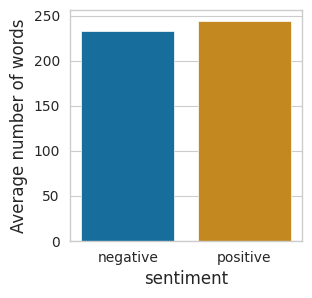

In [14]:
movies_df['clean_review'] = [' '.join(review) for review in movies_df['clean_tokens']]
movies_df['num_words'] = [len(review) for review in movies_df['clean_tokens']]
# A barplot of the average number of words in a review against sentiment
plt.figure(figsize = (3,3))
sns.barplot(data = movies_df, x = 'sentiment', y = 'num_words', ci = True)
plt.ylabel("Average number of words")

From the above barplot, we can see that on average, positive reviews have more words than negative reviews. Next, we will check the distribution of the number of words in positive reviews and negative reviews.

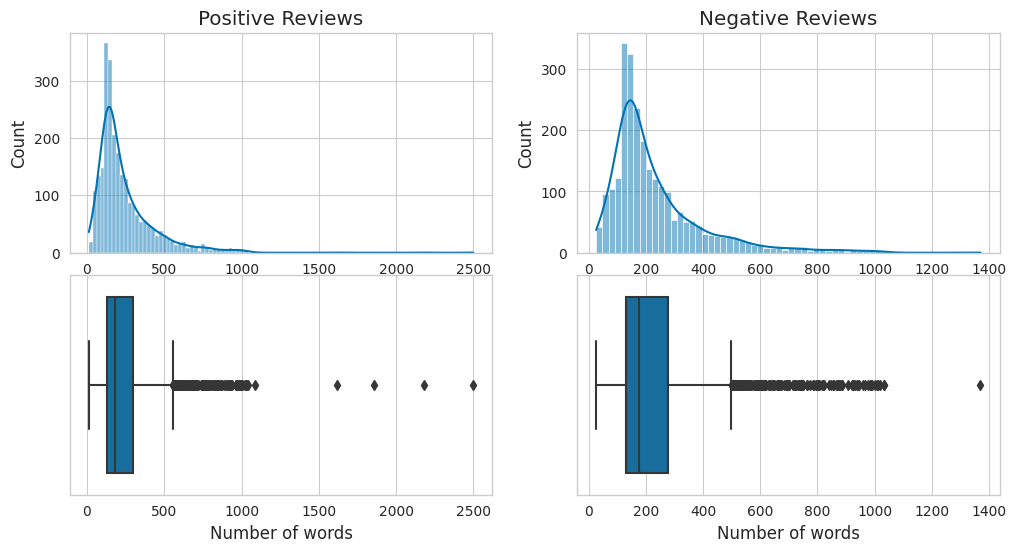

In [15]:
fig, ax =plt.subplots(2,2, figsize = (12,6))
sns.histplot(data = movies_df[movies_df['sentiment']=='positive'], x = 'num_words',  ax =ax[0,0], kde = True)
ax[0,0].set_title("Positive Reviews")
ax[0,0].set_xlabel('Number of words')
sns.histplot(data = movies_df[movies_df['sentiment']=='negative'], x = 'num_words',  ax =ax[0,1], kde = True)
ax[0,1].set_title("Negative Reviews")
ax[0,1].set_xlabel('Number of words')
sns.boxplot(data = movies_df[movies_df['sentiment']=='positive'], x = 'num_words', ax = ax[1,0])
ax[1,0].set_xlabel('Number of words')
sns.boxplot(data = movies_df[movies_df['sentiment']=='negative'], x = 'num_words', ax = ax[1,1])
ax[1,1].set_xlabel('Number of words')
plt.subplots_adjust(hspace=0.1)
plt.show()

As we can see, the plots bear a lot of similarity with the plots for number of characters. Next, we will perform an hypothesis test to see if the difference we saw in the average number of words across positive sentiments is significant.

H0: There is no difference between the average number of words in positive reviews and negative reviews.

H1: The average number of words in positive reviews is greater than in negative reviews.

## Is the difference in number of characters significant?

In [16]:
# subsetting for positive and negative reviews
positive_df = movies_df[movies_df['sentiment']=='positive']
negative_df = movies_df[movies_df['sentiment']=='negative']
#performing the hypothesis test
pingouin.mwu(x = positive_df['num_words'],
              y = negative_df['num_words'],
              alternative = 'greater')

,U-val,alternative,p-val,RBC,CLES
MWU,3167186.0,greater,0.203956,0.013516,0.506758


From the above, a p-value of 0.515 suggests that we fail to reject the null and conclude that there is no significant difference in the number of words in positive and negative reviews.

A RBC (Rank Biserial Correlation) value of 0 there is a negligible effect of review sentiment on the number of words in a review.

Lastly, a CLES (Common Language Effect Size) value 0.499 suggests that there is approximately a 50% chance of getting a positive review with more characters than a negative review.

## Is there a difference between the average word length between positive reviews and negative reviews?

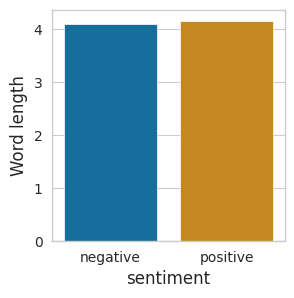

In [17]:
#Calculating average word length
average_word_length = [np.mean(np.array([len(word) for word in review]))for review in movies_df['clean_tokens']]
#Creating a column word_length
movies_df['word_length'] = np.round(average_word_length, 3)
plt.figure(figsize = (3,3))
sns.barplot(data = movies_df, x = 'sentiment', y = 'word_length', ci = True)
plt.ylabel('Word length')
plt.show()

From the above plot, we can see that the average word length of positive reviews is slightly higher than the average wordlength of negative reviews. We will test whether this difference is significant, but before then, we will have a look at the distribution of word lengths across both sentiments.

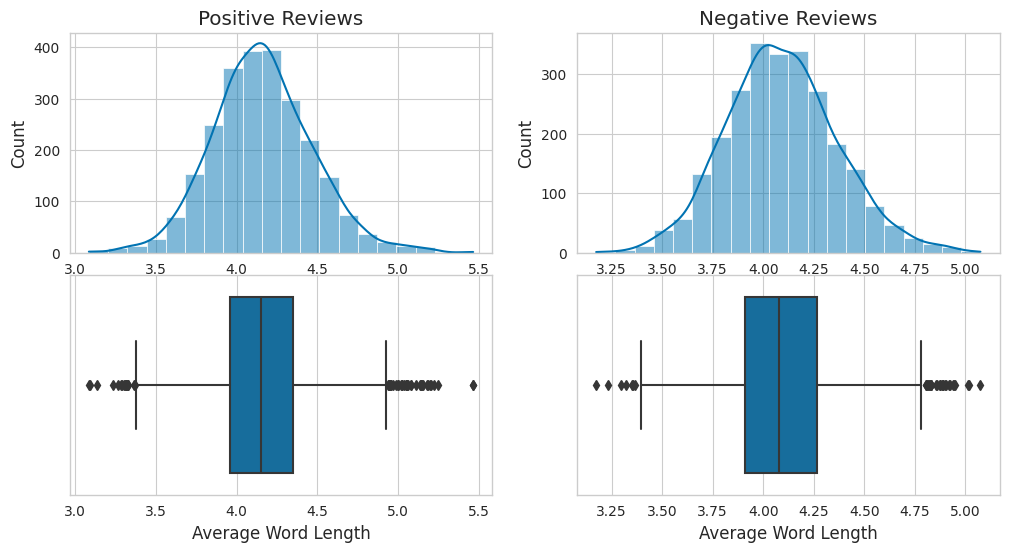

In [18]:
fig, ax =plt.subplots(2,2, figsize = (12,6))
sns.histplot(data = movies_df[movies_df['sentiment']=='positive'], x = 'word_length',  ax =ax[0,0], kde = True, bins = 20)
ax[0,0].set_title("Positive Reviews")
ax[0,0].set_xlabel('Average Word Length')
sns.histplot(data = movies_df[movies_df['sentiment']=='negative'], x = 'word_length',  ax =ax[0,1], kde = True, bins = 20)
ax[0,1].set_title("Negative Reviews")
ax[0,1].set_xlabel('Average Word Length')
sns.boxplot(data = movies_df[movies_df['sentiment']=='positive'], x = 'word_length', ax = ax[1,0])
ax[1,0].set_xlabel('Average Word Length')
sns.boxplot(data = movies_df[movies_df['sentiment']=='negative'], x = 'word_length', ax = ax[1,1])
ax[1,1].set_xlabel('Average Word Length')
plt.subplots_adjust(hspace=0.1)
plt.show()

From the histograms, we can see that word lengths in both positive and negative reviews are normally distributed with an average word length of around 4.2. 

From the boxplots, we can see that the spread of wordlengths in positive reviews is larger than in negative reviews. This can be evidenced by the that values beyond a word length of 5 can be considered outliers in positive reviews whereas this value seems to be approximately 4.9 in negative reviews.

In both positive and negative reviews, we can see that worlengths below approximately 3.2 can be considered outliers too.
Next, we will have a look at these outlier values to confirm is they are indeed made up of valid words.

In [19]:
# Subsetting for outliers
#movies_df[(movies_df['word_length'] > 5 )| (movies_df['word_length'] < 3.2)]['clean_tokens'].values

## Is the difference in average word lengths in positive and negative reviews significant?

In [20]:
# subsetting for positive and negative reviews
positive_df = movies_df[movies_df['sentiment']=='positive']
negative_df = movies_df[movies_df['sentiment']=='negative']
#performing the hypothesis test
pingouin.mwu(x = positive_df['word_length'],
              y = negative_df['word_length'],
              alternative = 'greater')

,U-val,alternative,p-val,RBC,CLES
MWU,3538009.0,greater,2.898088e-16,0.132181,0.56609


From the above, a p-value of 0 suggests that we reject the null and conclude that positive reviews have greater word length than negative reviews.

A RBC (Rank Biserial Correlation) value of 0.114 suggests that even though the word lengths in positive reviews are larger, the effect size is small.

Lastly, a CLES (Common Language Effect Size) value 0.55 suggests that there is approximately a 55% chance of getting a positive review with more characters than a negative review.

In conclusion, even though positive reviews appear to have greater word length on average; the effect size is small meaning that it might not be meaningful in practial context.
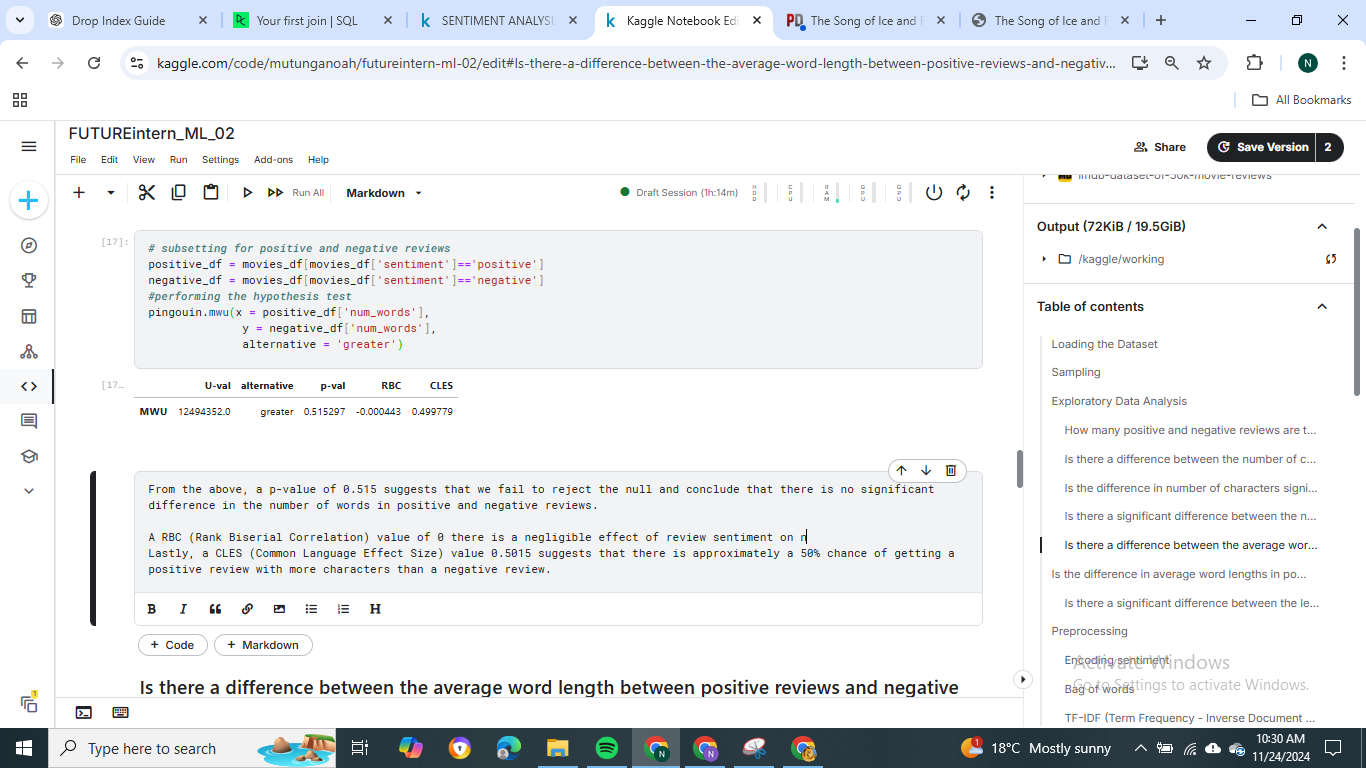

## Which words are most frequent in either positive or negative reviews?

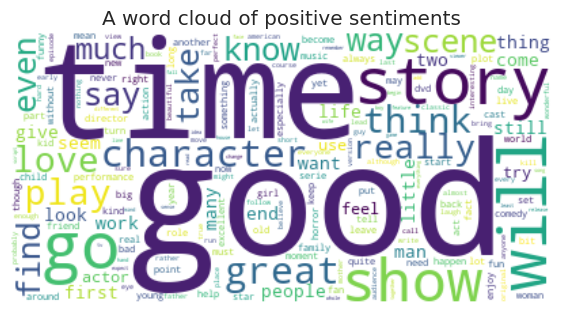

In [21]:
def sentiment_cloud (df,col,title):
    sentiment_text = " ".join(df[col])
    my_wordcloud = WordCloud(background_color='white', stopwords=STOPWORDS.union(['s','film','movie','one','make','see','well','watch']), random_state = 42).generate(sentiment_text)
    plt.figure(figsize = (7,5))
    plt.imshow(my_wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
sentiment_cloud(positive_df, 'clean_review', 'A word cloud of positive sentiments')

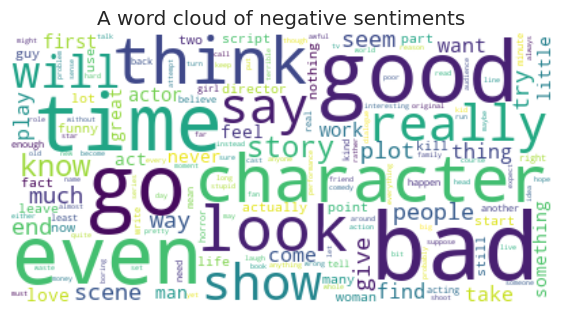

In [22]:
sentiment_cloud(negative_df, 'clean_review', 'A word cloud of negative sentiments')

Next, we will plot count plots of the top 15 word frequencies in both negative and positive reviews.

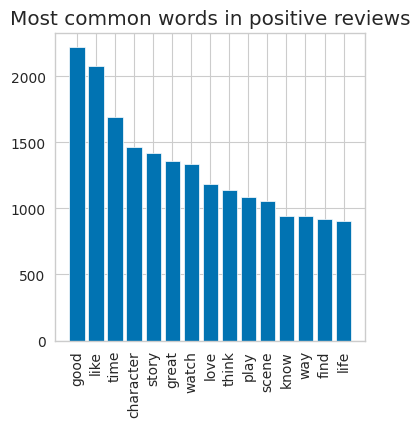

In [23]:
STOP_WORDS.update(['s','film','movie','one','make','see','I'])
def remove_stopwords_and_plot(df, column, title):
    no_stopwords = [word for sublist in df[column] for word in sublist if word not in STOP_WORDS]
    top_10 = Counter(no_stopwords).most_common(15)
    x,y = zip(*top_10)
    plt.figure(figsize = (4,4))
    plt.bar(x,y)
    plt.xticks(rotation = 90)
    plt.title(title)
    plt.show()
remove_stopwords_and_plot(positive_df, 'clean_tokens', 'Most common words in positive reviews')


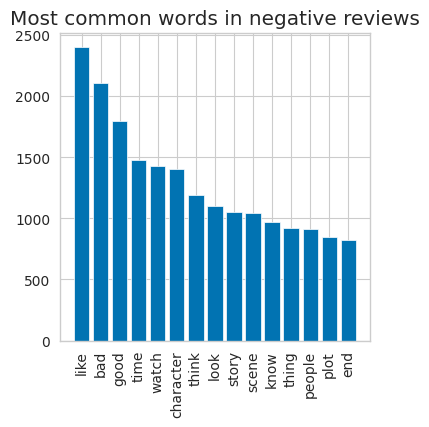

In [24]:
remove_stopwords_and_plot(negative_df, 'clean_tokens', 'Most common words in negative reviews')


# Topic Identification

In [25]:
movies_copy = movies_df.copy()
def remove_named_entities(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.ent_type_])
movies_copy['clean_review'] = movies_copy['clean_review'].apply(remove_named_entities)
positive_df = movies_copy[movies_copy['sentiment'] == 'positive'].reset_index(drop = True)
negative_df = movies_copy[movies_copy['sentiment'] == 'negative'].reset_index(drop = True)

## Term Frequency - Inverse Document Frequency

In [26]:
# Initializing a TF-IDF vectorizer
custom_stopwords = list(set(nlp.Defaults.stop_words).union({"really", "like", "just", "say", "thing", "want"}))
tfidf_positive = TfidfVectorizer(max_features = 5000, stop_words = custom_stopwords, lowercase = True, min_df = 0.01, max_df = 0.95, ngram_range=(1,3))
tfidf_negative = TfidfVectorizer(max_features = 5000, stop_words = custom_stopwords, lowercase = True, min_df = 0.01, max_df = 0.95, ngram_range=(1,3))
# Fitting and transforming TF-IDF vectorizers
positive_tfidf = tfidf_positive.fit_transform(positive_df['clean_review'])
negative_tfidf = tfidf_negative.fit_transform(negative_df['clean_review'])

## Non-negative Matrix Factorization

In [27]:
%%capture
# Initializing an NMF models
nmf_positive_model = NMF(n_components = 7,random_state = 42, l1_ratio= 0.5, alpha_H = 0.0001, alpha_W = 0.0001)
nmf_negative_model = NMF(n_components = 7,random_state = 42, l1_ratio= 0.5, alpha_H = 0.0001, alpha_W = 0.0001)
# Fitting and transforming NMF models
nmf_positive_model.fit_transform(positive_tfidf)
nmf_negative_model.fit_transform(negative_tfidf)


In [28]:
corpus = [[word for word in word_tokenize(review) if word not in custom_stopwords] for review in tqdm(movies_copy['clean_review'])]
# Create a dictionary (mapping of word to ID)
dictionary = Dictionary(corpus)

100%|██████████| 5000/5000 [00:08<00:00, 622.83it/s]


In [29]:
num_top_words = 10
feature_names = tfidf_positive.get_feature_names_out()

positive_topics = []
for topic_idx, topic in enumerate(nmf_positive_model.components_):
    top_words_idx = topic.argsort()[-num_top_words:]
    top_words = [feature_names[i] for i in top_words_idx]
    positive_topics.append(top_words)

In [30]:
num_top_words = 10
feature_names = tfidf_negative.get_feature_names_out()

negative_topics = []
for topic_idx, topic in enumerate(nmf_negative_model.components_):
    top_words_idx = topic.argsort()[-num_top_words:]
    top_words = [feature_names[i] for i in top_words_idx]
    negative_topics.append(top_words)

In [31]:
# Create a CoherenceModel using the top words from each topic
coherence_model = CoherenceModel(topics=negative_topics, dictionary=dictionary, texts=corpus, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Positive Coherence Score: {coherence_score}")

Positive Coherence Score: 0.5154933888138398


In [32]:
# Create a CoherenceModel using the top words from each topic
coherence_model = CoherenceModel(topics=positive_topics, dictionary=dictionary, texts=corpus, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Positive Coherence Score: {coherence_score}")


Positive Coherence Score: 0.5025809533814632


A coherence scores of 0.5 suggests that the topics identified by our NMF model have moderate interpretability and distinction. While this indicates a reasonable performance, there may still be room for improving topic separation or word alignment within topics to achieve higher coherence. 

In [33]:
print("Top words for each topic:")
for idx, topic in enumerate(positive_topics):
    print(f"Topic {idx}: {', '.join(topic)}")

Top words for each topic:
Topic 0: people, life, know, scene, play, think, great, time, story, good
Topic 1: worth, think, laugh, recommend, love watch, enjoy, watch time, time watch, time, watch
Topic 2: family, relationship, life, great, beautiful, favorite, fall, love story, fall love, love
Topic 3: quality, favorite, dvd, new, air, television, season, tv, series, episode
Topic 4: actor, classic, fun, star, joke, funniest, hilarious, laugh, comedy, funny
Topic 5: fault, father, feel good, act, animation, different, actor, main, main character, character
Topic 6: great, band, number, dancing, soundtrack, musical, music, dance, sing, song


## Positive Topic Explanation

* ### Topic 0
The first topic seems to be about reviews on general discussion about movies. This can be evidenced by the presence of words such as life, scene, character and story.

* ### Topic 1
The second topic seems to be about reviews that revolve around the act and time spend watching movies. This can be shown by the presence of words such as dvd, time, watch etc.

* ### Topic 2
The third topic seems to be composed of reviews about the great quality of the films that were watched. This can be evidenced by the presence of words such as wonderful, beautiful and love.

* ### Topic 3
The fourth topic seems to be composed of reviews about specific movies as evidenced by words such as episode, series and season.

* ### Topic 4
The fifth topic is composed of reviews about actors, specifically how wonderful they were. This can be shown by the presence of words such as actress, actor, great job, great actor etc.

* ### Topic 5
The sixth topic is made of reviews that discuss about humor in some of the scenes in the films. This can be shown by the presence of words such as humor, joke, funniest, hilarious laugh etc.

* ### Topic 6
The seventh topic consists of reviews that comment on the nature of acting. This can be shown by the presence of words such as good performance, think good, pretty good etc.


In [34]:
print("Top words for each topic:")
for idx, topic in enumerate(negative_topics):
    print(f"Topic {idx}: {', '.join(topic)}")

Top words for each topic:
Topic 0: people, know, time, scene, look, story, think, watch, character, good
Topic 1: terrible, act bad, awful, horrible, acting, act, bad act, watch, bad bad, bad
Topic 2: version, love, character, change, adaptation, story, novel, read, read book, book
Topic 3: think, gag, watch, stupid, try, humor, laugh, joke, comedy, funny
Topic 4: girl, death, die, people, end, boyfriend, guy, kill people, killer, kill
Topic 5: believe, boring, time watch, waste money, time money, watch, money, time, waste time, waste
Topic 6: cheap, horrible, look, horror, acting, creature, laughable, special, special effect, effect


## Negatve Topic Explanation

* ### Topic 0
This topic seems to be about reviews that touch on many aspects of the movies. Words such as time and watch may indicate reviews on the time spend watching movies. Words such as story, scene, plots and character may be found on reviews that touch on specific aspects of the movies.

* ### Topic 1
The second topic seems to be made of reviews that critisize the acting in the movie. This can be shown by the presence of words such as terrible, bad act, awful, horrible etc

* ### Topic 2
The third topic seems to consist of reviews that critisize the adaptation of the film/ movie from the original source. This can be evidenced by the presence of words such as version, change, adaptation, novel, read, book etc.

* ### Topic 3
The fourth topic seems to be about reviews that touch on poor attempts at humor. This can be evidenced by the presence of words such as try hard, unfunny, stupid, joke etc.

* ### Topic 4
This topic appears to capture reviews expressing dissatisfaction or emotional disconnection with the movie. The presence of words like fall asleep and fall love suggests viewers may have been either bored or unengaged with the storyline. Meanwhile, terms like fake, life, and people think might indicate broader critiques of the movie’s themes, characters, or believability. This mix of sentiments suggests that the reviews reflect a general sense of disappointment, whether stemming from a lack of authenticity, an overreliance on clichés, or failure to resonate with the audience.

* ### Topic 5
The sixth topic seems to touch on reviews that felt it was not worthwhile watching the movie. The sixth topic is characterized by the presence of words such as; boring, waste time, waste money, horrible etc.

* ### Topic 6
The sixth topic seems to be about reviews that critisize the genre and the emotions different movies elicited from their viewers. This can be evidenced by the presence of words such as suspense, horror, scare, genre and monsters.

# Sentiment Analysis

## TextBlob pretrained model

In [35]:
tqdm.pandas()
movies_copy['polarity'] = movies_df['clean_review'].progress_apply(lambda x: TextBlob(x).sentiment.polarity)

100%|██████████| 5000/5000 [00:06<00:00, 780.68it/s]


In [36]:
movies_copy['textblob_sentiment'] = np.where(movies_copy['polarity']>0, 'positive', 'negative')
print(f"The accuracy of textblob's rule based sentiment analysis model is: {accuracy_score(movies_copy['sentiment'].values, movies_copy['textblob_sentiment'].values)}")
print(f"The confusion matrix of textblob's rule based sentiment analysis model is: \n{confusion_matrix(movies_copy['sentiment'].values, movies_copy['textblob_sentiment'].values)}")
print(f"The classification report of textblob's rule based sentiment analysis model is:\n {classification_report(movies_copy['sentiment'].values, movies_copy['textblob_sentiment'].values)}")

The accuracy of textblob's rule based sentiment analysis model is: 0.6938
The confusion matrix of textblob's rule based sentiment analysis model is: 
[[1139 1371]
 [ 160 2330]]
The classification report of textblob's rule based sentiment analysis model is:
               precision    recall  f1-score   support

    negative       0.88      0.45      0.60      2510
    positive       0.63      0.94      0.75      2490

    accuracy                           0.69      5000
   macro avg       0.75      0.69      0.68      5000
weighted avg       0.75      0.69      0.68      5000



From the above results, we can see that textblob's sentiment analysis model performs poorly when it comes to classifying the negative class resulting in many false positives. This keads to a poor precision in the positive class (**0.63**) and a poor recall (**0.44**) in the negative class.

Our textblob model achieves an accuracy of **0.69** and will serve as our baseline value for accuracy.

Next we will preprocess our data in order to make it ready for modelling.

## Data Preprocessing

### Encoding the response variable

In [37]:
movies_copy['sentiment'] = pd.get_dummies(movies_copy['sentiment'], drop_first = True).astype(int)

In [38]:
## Subsetting the response variable 
y = movies_copy['sentiment'].values

## `CountVectorizer`: A bag of words

In [39]:
#Removing html tags
movies_copy['review'] = [re.sub(r'<br\s*/?>', '', text) for text in movies_copy['review']]
#removing punctuations
movies_copy['review'] = [re.sub(r"[^\w+]",' ', text) for text in movies_copy['review']]

In [40]:
#Initializing CountVectorizer object
countvectorizer = CountVectorizer(max_features = 5000, ngram_range = (1,2), max_df = 5000, min_df = 10)
#Transforming our review column to a bag of words
X_cv = countvectorizer.fit_transform(movies_copy['review'])

### Splitting our data

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_cv, y, test_size = 0.3, random_state = 42, stratify = y)

## Models based on `CountVectorizer`

### Logistic Regression

### Hyperparameter tuning using cross validation

In [42]:
kf = KFold(n_splits = 7, shuffle = True, random_state = 42)
param_grid = {'penalty': ['l2','l1'],
             'C' : [0.01,1,10],
              }
logreg_htcv = LogisticRegression(max_iter = 2000)
# Creating a hyperparameter tuning function
def hyper_params_tuning(param_grid, model):
    model_cv = GridSearchCV(model, param_grid, cv = kf, n_jobs = -1)
    model_cv.fit(X_train.astype('float64'), y_train)
    print(f"Best parameters: {model_cv.best_params_}, \nBest score:{model_cv.best_score_}")
#calling the function
hyper_params_tuning(param_grid, logreg_htcv)
    

Best parameters: {'C': 0.01, 'penalty': 'l2'}, 
Best score:0.8314285714285713


From the results above, we can see that the best value for the hyperparameter C (inverse of regularization strength) is 0.01 and the best regularization technique is ridge regularization (l2). 

Next, we will fit our LogisticRegression model based on these hyperparameters.

In [43]:
# initializing a logistic regression model
logreg = LogisticRegression(penalty = 'l2', C = 0.01)
def results(model, model_name):
    model.fit(X_train.astype("float64"), y_train)
    pred = model.predict(X_test.astype('float64'))
    print(f"The accuracy score for the {model_name} is: {np.round(accuracy_score(y_test, pred),2)}")
    print(f"The confusion matrix for the {model_name} is: \n {confusion_matrix(y_test, pred)}")
    print(f"The classification report for the {model_name} is:\n {classification_report(y_test, pred)}")
results(logreg, "Logistic Regression Model")
    


The accuracy score for the Logistic Regression Model is: 0.83
The confusion matrix for the Logistic Regression Model is: 
 [[623 130]
 [119 628]]
The classification report for the Logistic Regression Model is:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83       753
           1       0.83      0.84      0.83       747

    accuracy                           0.83      1500
   macro avg       0.83      0.83      0.83      1500
weighted avg       0.83      0.83      0.83      1500



Our logistic regression model achieves an **accuracy of 0.834**, which means the model correctly classifies **83.4\%** of all observations.

Given that the purpose of predicting sentiments is to **gather valuable feedback for improving our services/product**s, it's important to focus on **recall for the negative class**. This is because recall will tell us the **proportion of negative reviews that are correctly** identified as negative—helping us avoid missing any valuable negative feedback that could point to **areas for improvement**.

From the classification report, we can see that the **recall for negative reviews is 0.83**. This means that **83\% of negative reviews** are correctly classified as negative, ensuring that a significant portion of critical feedback is captured.

Additionally, the model performs almost equally well in classifying reviews from either the positive or negative class, as reflected by the **precision values of 0.84 for negative reviews** and **0.83 for positive reviews**. This shows that the model is fairly balanced and does not favor one sentiment over the other.

### Naive Bayes

### Hyperparameter tuning and cross-validation

In [44]:
param_grid = {
    'alpha': [0.005,0.01, 0.05],
    'fit_prior': [True, False]}
# Initialize model
nb = MultinomialNB()
hyper_params_tuning(param_grid, nb)

Best parameters: {'alpha': 0.05, 'fit_prior': False}, 
Best score:0.8317142857142857


From the above results, we can see that our best choice for *alpha* is **0.01** and *fit_prior* should be set to **True** for optimal results

In [45]:
nb = MultinomialNB(alpha = 0.01, fit_prior = True)
results(nb, 'Naive Bayes Model')

The accuracy score for the Naive Bayes Model is: 0.82
The confusion matrix for the Naive Bayes Model is: 
 [[608 145]
 [124 623]]
The classification report for the Naive Bayes Model is:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       753
           1       0.81      0.83      0.82       747

    accuracy                           0.82      1500
   macro avg       0.82      0.82      0.82      1500
weighted avg       0.82      0.82      0.82      1500



From the above results, our **Naive Bayes** model achieves an accuracy of **0.82**, meaning that **82\%** of all total observations are correctly classified.

We can also see that the recall for negative reviews is **0.81**, which is lower than the recall attained by our logistic regression model of **0.83**.

Lastly, while the model does not seem to be overly biased towards any class as evidenced by the precision values of **0.83** and **0.81** for negative and positive sentiments respectively, the class balance is poorer compared to what was achieved by the logistic regression model.

### Support Vector Machine

### Hyperparameter tuning and cross-validation

In [46]:
param_grid = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l2', 'l1'],
    'loss': ['hinge', 'squared_hinge'],
    'tol': [1e-4, 1e-3]}
svm = LinearSVC(max_iter = 5000)
hyper_params_tuning(param_grid, svm)

Best parameters: {'C': 0.01, 'loss': 'hinge', 'penalty': 'l2', 'tol': 0.0001}, 
Best score:0.8394285714285713


Best hyperparameters are:
* `C` : 0.01
* `loss` : hinge
* `penalty` : l2
* `tol` : 0.0001

Next, we will fit a Support Vectors Machine Model based on these hyperparameters.

In [47]:
svm = LinearSVC(C = 0.01, loss = 'hinge', penalty = 'l2', tol = 0.0001)
results(svm, 'Support Vector Machine Model')

The accuracy score for the Support Vector Machine Model is: 0.83
The confusion matrix for the Support Vector Machine Model is: 
 [[608 145]
 [117 630]]
The classification report for the Support Vector Machine Model is:
               precision    recall  f1-score   support

           0       0.84      0.81      0.82       753
           1       0.81      0.84      0.83       747

    accuracy                           0.83      1500
   macro avg       0.83      0.83      0.83      1500
weighted avg       0.83      0.83      0.83      1500



Support Vector Machine Learning Model has an accuracy of **0.83**. This means that it correctly classifies **83\%** of all reviews. 

On recall of negative reviews, it performs equally as well as Naive Bayes Model but poorly than the logistic regression model. So far, Logistic regression model is still the best model.

### Ridge Regression

### Hyperparameter tuning and Cross-Validation

In [48]:
param_grid  = {
    'alpha': [150, 200, 250],
    'solver': ['auto', 'lsqr', 'cholesky'],
    'fit_intercept': [True, False],
    'max_iter': [50,100,200],
    'tol': [1e-4, 1e-3]}
rr = RidgeClassifier()
hyper_params_tuning(param_grid, rr)

Best parameters: {'alpha': 200, 'fit_intercept': True, 'max_iter': 50, 'solver': 'lsqr', 'tol': 0.0001}, 
Best score:0.8408571428571429


From the above results, we can see that the best hyperparameters are:
* `alpha` : 200
* `fit_intercept` : True
* `solver` : lsqr
* `max_iter` : 50
* `tol` : 0.0001

In [49]:
rc = RidgeClassifier(alpha = 200, fit_intercept = True, solver = 'lsqr', max_iter = 50, tol = 0.0001)
results(rc, "Ridge Classifier Model")

The accuracy score for the Ridge Classifier Model is: 0.83
The confusion matrix for the Ridge Classifier Model is: 
 [[614 139]
 [109 638]]
The classification report for the Ridge Classifier Model is:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83       753
           1       0.82      0.85      0.84       747

    accuracy                           0.83      1500
   macro avg       0.84      0.83      0.83      1500
weighted avg       0.84      0.83      0.83      1500



The ridge model achieves an accuracy of **0.83**. This means that it correctly classifies **83\%** of all reviews.

This is the second best performing model in terms of the recall of negative reviews with a score of **0.82** after the logistic regression model.

### Light Gradient Boosting Machine (LightGBM)

### Hyperparameter tuning and Cross - Validation

In [50]:
warnings.filterwarnings('ignore')
param_grid = {"learning_rate" : [0.3,0.25,0.2],
             "n_estimators" : [300,275,250]
             }
lgbm = lgb.LGBMClassifier(verbose = -1)
hyper_params_tuning(param_grid, lgbm)

Best parameters: {'learning_rate': 0.25, 'n_estimators': 300}, 
Best score:0.8462857142857142


Best hyperparameters:
* `learning_rate` : 0.25
*  `n_estimators` : 275

In [51]:
lgbm = lgb.LGBMClassifier(verbose = -1, learning_rate = 0.25, n_estimators = 275)
results(lgbm, "Light Gradient Boosting Model")

The accuracy score for the Light Gradient Boosting Model is: 0.83
The confusion matrix for the Light Gradient Boosting Model is: 
 [[614 139]
 [111 636]]
The classification report for the Light Gradient Boosting Model is:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83       753
           1       0.82      0.85      0.84       747

    accuracy                           0.83      1500
   macro avg       0.83      0.83      0.83      1500
weighted avg       0.83      0.83      0.83      1500



Across all metrics, LogisticRegression is still the best.

Next, we will see how these models would perform had they been fit using a Term Frequency Inverse Document Frequency Data.

## TF-IDF  (Term Frequency - Inverse Document Frequency)

In [52]:
tfidf = TfidfVectorizer(max_features = 5000, ngram_range = (1,2))
X_tfidf = tfidf.fit_transform(movies_copy['clean_review'])

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.3, random_state = 42, stratify = y)

## Models Based on TF-IDF

### Logistic Regression

### Hyperparameter tuning and cross validation

In [54]:
param_grid = {'penalty': ['l2','l1'],
             'C' : [3,3.1,3.15],
              }
lrm = LogisticRegression(max_iter = 2000)
# Creating a hyperparameter tuning function
def hyper_params_tuning(param_grid, model):
    model_cv = GridSearchCV(model, param_grid, cv = kf, n_jobs = -1)
    model_cv.fit(X_train, y_train)
    print(f"Best parameters: {model_cv.best_params_}, \nBest score:{model_cv.best_score_}")
#calling the function
hyper_params_tuning(param_grid, lrm)

Best parameters: {'C': 3.1, 'penalty': 'l2'}, 
Best score:0.8531428571428572


**Best Parameters:**
* **`C`**: 3.1
* **`penalty`**: l2

In [55]:
logreg_tfidf = LogisticRegression(C=3.1, penalty = 'l2')
def results(model, model_name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f"The accuracy score for the {model_name} is: {np.round(accuracy_score(y_test, pred),2)}")
    print(f"The confusion matrix for the {model_name} is: \n {confusion_matrix(y_test, pred)}")
    print(f"The classification report for the {model_name} is:\n {classification_report(y_test, pred)}")
results(logreg_tfidf, "Logistic Regression Model Based on TF-IDF")


The accuracy score for the Logistic Regression Model Based on TF-IDF is: 0.84
The confusion matrix for the Logistic Regression Model Based on TF-IDF is: 
 [[608 145]
 [ 93 654]]
The classification report for the Logistic Regression Model Based on TF-IDF is:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84       753
           1       0.82      0.88      0.85       747

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500



From the results, we observe that while using **TF-IDF improved the overall accuracy** of the **logistic regression model** to **0.84**, it came at the **cost of a drop in the recall of the negative class**—our key metric of interest. This score decreased from **0.83 (using CountVectorizer)** to **0.81 with TF-IDF**.

The **drop in recall**, although minor, **is significant enough** to impact **our choice of model**. Since our primary **focus is on maximizing the recall of the negative class**, the **logistic regression model based on CountVectorizer** emerges as the **better choice**, balancing accuracy and our critical evaluation metric.

### Naive Bayes

### Hyperparameter tuning and cross-validation

In [56]:
param_grid = {
    'alpha': [0.1,0.2,0.3,0.4],
    "fit_prior" : [True, False]
}
nb_tfidf = MultinomialNB()
hyper_params_tuning(param_grid, nb_tfidf)

Best parameters: {'alpha': 0.2, 'fit_prior': False}, 
Best score:0.8485714285714285


In [57]:
nb_tfidf = MultinomialNB(alpha = 0.3, fit_prior = False)
results(nb_tfidf, "Naive Bayes Model based on TF-IDF")

The accuracy score for the Naive Bayes Model based on TF-IDF is: 0.84
The confusion matrix for the Naive Bayes Model based on TF-IDF is: 
 [[605 148]
 [ 95 652]]
The classification report for the Naive Bayes Model based on TF-IDF is:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83       753
           1       0.81      0.87      0.84       747

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500



The Naive Bayes model using TF-IDF achieved **higher accuracy (0.84)** compared to **CountVectorizer (0.82)** while maintaining the same **recall for negative reviews (0.81)**.

**Conclusion:** **TF-IDF** improves **overall performance** without affecting recall, making it the **better choice**.

### Support Vector Machine

### Hyperparameter Tuning

In [58]:
param_grid = {
    'C': [0.2,0.3, 0.25],
    'penalty': ['l2', 'l1'],
    'loss': ['hinge', 'squared_hinge'],
    'tol': [1e-4, 1e-3, 1e-2]}
svm_tfidf = LinearSVC(max_iter = 5000)
hyper_params_tuning(param_grid, svm)

Best parameters: {'C': 0.2, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 0.0001}, 
Best score:0.8537142857142858


In [59]:
svm_tfidf = LinearSVC(C = 0.2, loss = 'squared_hinge', penalty = 'l2', tol = 0.0001)
results(svm_tfidf, 'Support Vector Machine Model')

The accuracy score for the Support Vector Machine Model is: 0.84
The confusion matrix for the Support Vector Machine Model is: 
 [[609 144]
 [ 91 656]]
The classification report for the Support Vector Machine Model is:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84       753
           1       0.82      0.88      0.85       747

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.85      0.84      0.84      1500



The **Support Vector Machine** model with TF-IDF achieves a higher accuracy **(0.84)** compared to CountVectorizer while maintaining the same recall **(0.81)** for negative reviews.

**Conclusion**: TF-IDF **improves the overall performance** while maintaining the same recall for negative reviews thus making it the **better choice**.

### Ridge Regression

### Hyperparameter tuning and cross-validation

In [60]:
param_grid  = {
    'alpha': [0.1,1,0.01],
    'solver': ['auto', 'lsqr', 'cholesky'],
    'fit_intercept': [True, False],
    'max_iter': [1,10,15],
    'tol': [1e-1, 1e-3, 1e-2]}
rc_tfidf = RidgeClassifier()
hyper_params_tuning(param_grid, rc_tfidf)

Best parameters: {'alpha': 1, 'fit_intercept': False, 'max_iter': 10, 'solver': 'lsqr', 'tol': 0.01}, 
Best score:0.8517142857142858


In [61]:
rc_tfidf = RidgeClassifier(alpha = 1, fit_intercept = False, max_iter = 10, solver = 'lsqr', tol = 0.01)
results(rc_tfidf, "Ridge Classifier Model")

The accuracy score for the Ridge Classifier Model is: 0.85
The confusion matrix for the Ridge Classifier Model is: 
 [[617 136]
 [ 86 661]]
The classification report for the Ridge Classifier Model is:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85       753
           1       0.83      0.88      0.86       747

    accuracy                           0.85      1500
   macro avg       0.85      0.85      0.85      1500
weighted avg       0.85      0.85      0.85      1500



**Ridge Classifier Model** based on **TF-IDF** achieves an accuracy of **0.85**, the highest so far compared to all other models. Unfortunately though, it's recall for the negative reviews remain the same at **0.82** as it was when we used CountVectorizer.

**Conclusion:** **TF-IDF** improves the performance of our ridge classifier while maintaining the recall score of the negative reviews thus making **TF-IDF** the better choice.

### Light Gradient Boosting Machine

### Hyperparameter tuning and cross-validation

In [62]:
warnings.filterwarnings('ignore')
param_grid = {"learning_rate" : [0.2,0.15],
             "n_estimators" : [250,275]
             }
lgbm_tfidf = lgb.LGBMClassifier(verbose = -1)
hyper_params_tuning(param_grid, lgbm_tfidf)

Best parameters: {'learning_rate': 0.2, 'n_estimators': 275}, 
Best score:0.8400000000000001
